**Import necessary packages**

In [1]:
from pyspark.sql import SQLContext
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, StandardScaler, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline, Transformer
from pyspark.sql.functions import rand
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml.param.shared import HasOutputCols, Param, Params
from pyspark.sql.functions import monotonically_increasing_id

from sklearn.preprocessing import RobustScaler

import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd# load and evaluate a saved model
import datetime

from sklearn import preprocessing

# Keras / Deep Learning
"""
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers, regularizers
from keras.optimizers import Adam
"""

from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,GRU, Input, ConvLSTM2D, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Elephas for Deep Learning on Spark
from elephas.ml_model import ElephasEstimator
import numpy as np

WARNING


**Custom Transformer**

In [2]:
# CUSTOM TRANSFORMER ----------------------------------------------------------------
class ModelPredict(Transformer, HasOutputCols, DefaultParamsReadable, DefaultParamsWritable,):
    """
    A custom Transformer which drops all columns that have at least one of the
    words from the banned_list in the name.
    """

    def __init__(self, inputCol,outputCol):
        #super(ColumnDropper, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol
        print("Load model...")
        self.model = load_model("Model/20201231_233317_MEM_used_stack_LSTM_0.59MAE_1.62RMSE.h5")
        print("Done")
        
    #def _fit(self, dataset):
        

    def _transform(self, df) :
        #df = df.drop(*[x for x in df.columns if any(y in x for y in self.banned_list)])
        #df = df.na.drop()
        #Input = np.array(self.df[self.inputCol].values)
        #self.output = self.model.model_predict(Input)
        #print(self.inputCol)
        
        data = df.select(self.inputCol).collect()
        #print(data)
        #print(len(data))
        input_data = np.array(data)
        #print(input_data.shape)
        input_data = np.reshape(input_data,(1,input_data.shape[0],1))
        #print("( %d , %d , %d)"%(input_data.shape[0],input_data.shape[1],input_data.shape[2]))
        output = self.model.predict(input_data)
        #print(output)
        #return  df.withColumn("pred",df[self.inputCol])
        return output
    
class MyRobust(Transformer, HasOutputCols, DefaultParamsReadable, DefaultParamsWritable,):
    """
    A custom Transformer which drops all columns that have at least one of the
    words from the banned_list in the name.
    """

    def __init__(self, inputCol,outputCol):
        #super(ColumnDropper, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol
                

    def _transform(self, df) :
        #df = df.drop(*[x for x in df.columns if any(y in x for y in self.banned_list)])
        #df = df.na.drop()
        #Input = np.array(self.df[self.inputCol].values)
        #self.output = self.model.model_predict(Input)
        #print(self.outputCol)
        
        data = df.select(self.inputCol).collect()
        
        input_data = np.array(data)
        
        input_data = np.reshape(input_data,(input_data.shape[0],1))
        sc = RobustScaler()
        scaled_data = sc.fit_transform(input_data)
        scaled_data_pandas = pd.DataFrame(scaled_data, columns=[self.outputCol])
        #print(scaled_data_pandas.shape[0])
        scaled_data_df = spark.createDataFrame(scaled_data_pandas, [self.outputCol])
        scaled_data_df.count()
        scaled_data_df = scaled_data_df.withColumn("row_id",monotonically_increasing_id())
        df = df.withColumn("row_id",monotonically_increasing_id())
        df.show(60)
        #print(scaled_data_df.count())
        #print(scaled_data_df.count())
        #print("( %d , %d , %d)"%(input_data.shape[0],input_data.shape[1],input_data.shape[2]))
        df = df.join(scaled_data_df, ("row_id")).drop("row_id")
        #result_df.show(60)
        #print(df.count())
        #print(output)
        
        return  df
        #return output





**Select Features**

In [3]:
# Helper function to select features to scale given their skew
def select_features_to_scale(df, drop_cols=['timestamp','id']):
    
    # Empty Selected Feature List for Output
    selected_features = []
    
    
    # Select Features to Scale based on Inputs ('in32' type, drop 'ID' columns or others, skew bounds)
    feature_list = list(df.toPandas().columns.drop(drop_cols))
    
    # Loop through 'feature_list' to select features based on Kurtosis / Skew
    for feature in feature_list:

        selected_features.append(feature)
        #if df.toPandas()[feature].kurtosis() < -2 or df.toPandas()[feature].kurtosis() > 2:
            
            
    
    # Return feature list to scale
    return selected_features

**Read RDS CPU utilization dataset**

In [4]:
%%time


df = spark.read.csv("hdfs://master:9000/user/data/rds_cpu_utilization_e47b3b.csv", inferSchema=True, header=True)
# inferSchema referring to the type of the column
Data = df.collect()
Orgin_data = []

df = df.withColumn("id",monotonically_increasing_id())

for i in Data:
    Orgin_data.append(i[1])
    


CPU times: user 35.9 ms, sys: 18.3 ms, total: 54.3 ms
Wall time: 12.8 s


**Define Pipeline Stages**

In [5]:
stages = []
pred_value = []
unscaled_features = select_features_to_scale(df=df)
#stage
unscaled_assembler = VectorAssembler(inputCols=unscaled_features, outputCol="unscaled_features")
scaler = MinMaxScaler(min=0.0, max=1.0, inputCol="unscaled_features", outputCol="scaled_features")
#scaler = MyRobust(inputCol="unscaled_features", outputCol="scaled_features")
pred = ModelPredict(inputCol="scaled_features",outputCol="pred_value")



stages += [unscaled_assembler, scaler, pred]

Load model...
Done


**Fit Dataframe and Transform another Dataframe**

In [6]:
def get_scaler(orgin_list):
    orgin_array = np.array(orgin_list)
    data_scaler_minmax = preprocessing.MinMaxScaler(feature_range=(0, 1))
    data_scaled_minmax = data_scaler_minmax.fit_transform(orgin_array[:,1:2])
    
    return data_scaler_minmax

def inverse_data(df_transform,win_scaler):
    return win_scaler.inverse_transform(df_transform)


In [ ]:
pipeline = Pipeline(stages=stages)
diff_data_list = []
pred_value = []
for i in range(0,df.count()-60):
    window_df = df.filter(df.id.between(i,i+60-1))
    test = window_df.collect()
    
    
    window_scaler = get_scaler(test)
    #print(pred_time['timestamp'].show())
    #print(test[-1][0] + datetime.timedelta(minutes= 3))
    # Set Pipeline
    pred_time = test[-1][0] + datetime.timedelta(minutes= 3)
    #print(window_df.count())
    # Fit Pipeline to Data
    pipeline_model = pipeline.fit(window_df)

    # Transform Data using Fitted Pipeline
    df_transform = pipeline_model.transform(window_df)
    df_transform = inverse_data(df_transform,window_scaler)
    print("{}.Pred_value : {}".format(i,df_transform))
    df_transform = np.reshape(df_transform,(df_transform.shape[0]))
    pred_value.append(df_transform)
    diff_data = abs(df_transform-pred_value[i-1])
    diff_data_list.append(diff_data)
    print("{}.Diff_value : {}".format(i,diff_data))
    if diff_data >= 1:
        print("Warning : time:{} value:{}".format(pred_time,diff_data))

0.Pred_value : [[13.860018]]
0.Diff_value : [0.]
1.Pred_value : [[13.831706]]
1.Diff_value : [0.02831173]
2.Pred_value : [[13.798212]]
2.Diff_value : [0.033494]
3.Pred_value : [[13.767983]]
3.Diff_value : [0.03022861]
4.Pred_value : [[13.769469]]
4.Diff_value : [0.00148582]
5.Pred_value : [[13.788784]]
5.Diff_value : [0.01931477]
6.Pred_value : [[13.761993]]
6.Diff_value : [0.02679062]
7.Pred_value : [[13.766116]]
7.Diff_value : [0.00412273]
8.Pred_value : [[13.787139]]
8.Diff_value : [0.0210228]


**Plot data**

In [18]:
from IPython.core.pylabtools import figsize
figsize(13, 7) 

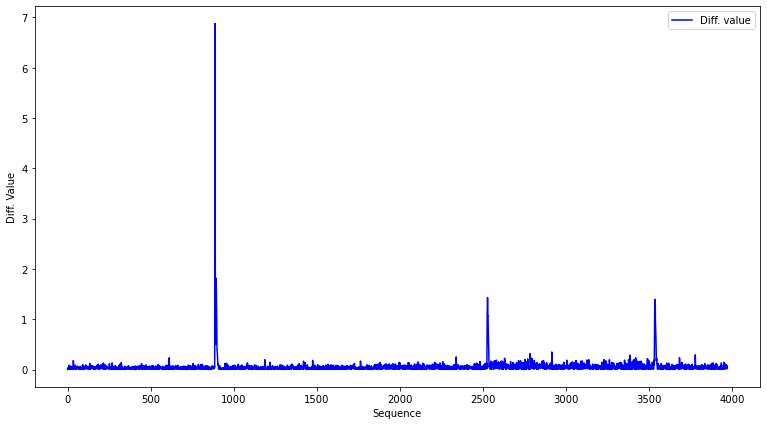

In [19]:
plt.plot(diff_data_list,color = 'blue', label = 'Diff. value')
plt.xlabel('Sequence')
plt.ylabel('Diff. Value')
plt.legend()

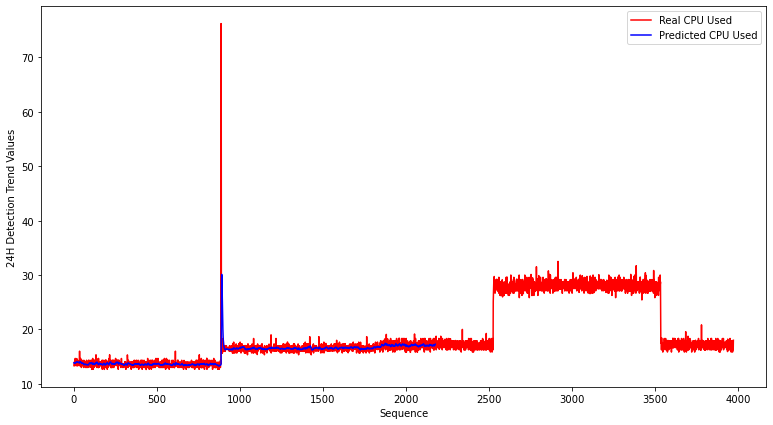

In [16]:
from matplotlib.animation import FuncAnimation

plt.plot(Orgin_data[60:],color = 'red', label = 'Real CPU Used')
plt.plot(pred_value,color = 'blue', label = 'Predicted CPU Used')
plt.xlabel('Sequence')
plt.ylabel('24H Detection Trend Values')
plt.legend()

MovieWriter ffmpeg unavailable; using Pillow instead.


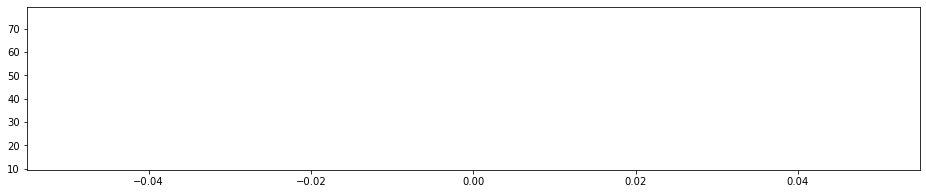

In [361]:
from matplotlib.animation import FuncAnimation

x = []
y = []

figure, ax = plt.subplots(figsize=(16,3))




def func_animate(i):
    
    ax.plot(Orgin_data[i])
    
    
    return ax,



ani = FuncAnimation(figure,
                    func_animate,
                    frames=4000,
                    interval=50)

ani.save(r'animation.gif', fps=10)

plt.show()


In [88]:
df_transform_fin = df_transform.select('scaled_features')

In [89]:
df_transform_fin

DataFrame[scaled_features: vector]